## Utils

In [ ]:
#taken from this StackOverflow answer: https://stackoverflow.com/a/39225039
import requests

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

file_id = '1-koULT_rZz1E6VJJVYa-hnLXdy6XSZe2'
destination = '/content/data.zip'
download_file_from_google_drive(file_id, destination)

In [ ]:
!unzip -q data.zip
!rm -rf data.zip

unzip:  cannot find or open data.zip, data.zip.zip or data.zip.ZIP.


# Regression with RANSAC for Robust curve fitting (2 mark)

For a given polynomial, \\
$$y_{i}=\beta_{0}+\beta_{1} x_{i}+\beta_{2} x_{i}^{2}+\cdots+\beta_{m} x_{i}^{m}+\varepsilon_{i}(i=1,2, \ldots, n)$$

we can express it in a form of matrix $\mathbf{X}$, a response vector or $\vec{y}$, a parameter vector $\vec{\beta}$, and a vector $\vec{\varepsilon}$ of random errors. The model can be represented as system of linear equations, i.e.



$$\left[\begin{array}{c}y_{1} \\ y_{2} \\ y_{3} \\ \vdots \\ y_{n}\end{array}\right]=\left[\begin{array}{ccccc}1 & x_{1} & x_{1}^{2} & \ldots & x_{1}^{m} \\ 1 & x_{2} & x_{2}^{2} & \ldots & x_{2}^{m} \\ 1 & x_{3} & x_{3}^{2} & \ldots & x_{3}^{m} \\ \vdots & \vdots & \vdots & \ddots & \vdots \\ 1 & x_{n} & x_{n}^{2} & \ldots & x_{n}^{m}\end{array}\right]\left[\begin{array}{c}\beta_{0} \\ \beta_{1} \\ \beta_{2} \\ \vdots \\ \beta_{m}\end{array}\right]+\left[\begin{array}{c}\varepsilon_{1} \\ \varepsilon_{2} \\ \varepsilon_{3} \\ \vdots \\ \varepsilon_{n}\end{array}\right]$$

$$or$$

$$\vec{y}=\mathbf{X} \vec{\beta}+\vec{\varepsilon}$$

For this system, we can calculate $\vec{\beta}$ by using the following formula,
$$
\widehat{\vec{\beta}}=\left(\mathbf{X}^{\top} \mathbf{X}\right)^{-1} \mathbf{X}^{\top} \vec{y}
$$

Using **RANSAC**, we want to avoid outliers in our curve fitting, and thus we will calculate multiple $\vec{\beta_i}$s using a set of datapoints. After calculating several $\vec{\beta_i}$ we will find the best value of ${\beta}$ using _least squares_.

In [ ]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

data_O2 = pd.read_csv("2nd_order.csv")
data_O3 = pd.read_csv("3rd_order.csv")
data_O4 = pd.read_csv("4th_order.csv")

# Calculating Beta to find the best fit in the given sample of data points.
class get_model:
    def fit(self, X, Y): #B (beta) = (inv(X'X)).(X'Y)
        X_T = X.transpose()
        Beta = (np.linalg.inv(X_T.dot(X))).dot(X_T.dot(Y))  
        return Beta

class Regression:
    def __init__(self,order,bias=True):
        """
        Initialize regressor
        :param order: order of the polynomial
        :param bias: boolean, True for our case
        """

        self.order = order
        self.bias = bias

        self.beta = np.zeros(order + bias)

    
    def solve(self,x,y,n):
        '''
        # For 1.5 marks
        Function to solve regression using RANSAC
        :param x: input
        :param y: output
        :param n: number of dataset per iteration
        :param iterations: number of iterations to find best beta 
        '''
        ## TODO
        
        threshold_lim = np.std(y)/5 # setting the threshold as 1/5th of the std deviation of y values after trying different percentage of the standard deviation and finding the best fit.
        max_inliers_overall = 0
        BestModel = None

        itr = 0
        sample_size = n

        Data_Overall = np.column_stack((x,y)) 
        DataSize = len(Data_Overall)
        iterations=10000

        # iterate for till the max iterations count
        for itr in range(iterations):

            # shuffle the entire data and take the first n entires of that data into the current sample
            np.random.shuffle(Data_Overall)
            curr_sample = Data_Overall[:sample_size, :]
            curr_model = get_model()
            try:
                estimated_model = curr_model.fit(curr_sample[:,:-1], curr_sample[:, -1:]) # fit the model on the current sample of n datapoints
                # count the number of datapoints lying within the threshold_lim
                y_hat = x.dot(estimated_model)
                sq_error = np.abs(np.square(y - y_hat.T))
                num_inliers = np.count_nonzero(sq_error < threshold_lim)

                # if the current number of inliers is more than the max inliers so far, then set the max inliers so far = current inliers count and set the best model to the current model
                if num_inliers > max_inliers_overall:
                    BestModel = estimated_model
                    max_inliers_overall = num_inliers
            except:
                pass

        ####
        # this is the best model obtained so far
        self.beta = BestModel
        return BestModel

    def get_func(self, coeff, x_value, y_value, order):
        for i in range(order+1):
          y_value += coeff[i]*(x_value**(order-i))
        return y_value

    def visualize(self,x,y,show=False):
        '''
        # For 0.5 marks
        function to visualize datapoints and optimal solution.
        '''
        # TODO
        coeff = self.beta
        order = self.order
        plt.figure(figsize =(10, 10))
        plt.scatter(x, y)
        x_func = np.linspace(x.min(),x.max(),100)
        y_func = np.zeros(len(x_func))
        y_func = self.get_func(coeff, x_func, y_func, self.order)
        plt.plot(x_func, y_func)

        ####
        if show:
            plt.show()
        return plt


## Solve and Visualize for 2nd Order (1.5 mark)

Load the dataset, solve the regression, and finally report the coeffecients, with best least square error. Also visualize it on graph.

In [ ]:
order = 2
model = Regression(order)
x = np.array(data_O2['x'])
x_square = np.power(x,2)
#printing the coefficents that give the best least square error
x = np.stack((x_square, x, np.ones((len(x)), dtype = int)), axis = 1)
model.solve(x,np.array(data_O2['y']),order*2)

array([[3.08132126],
       [2.14829886],
       [1.00311479]])

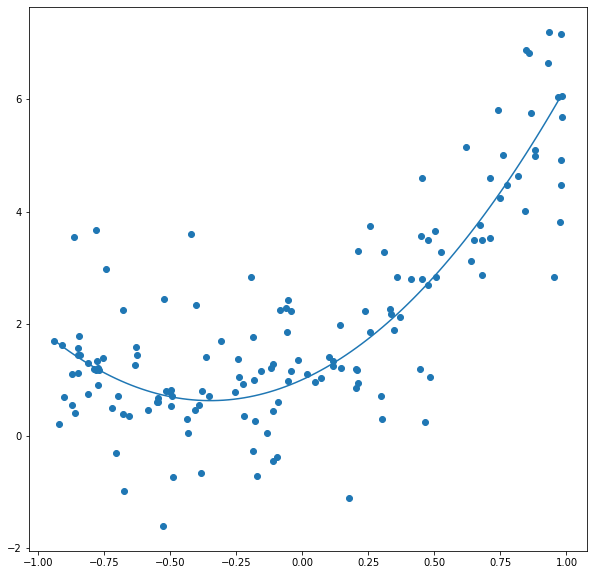

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

In [ ]:
model.visualize(data_O2['x'], data_O2['y'], True)

## Solve and Visualize for 3rd Order (1.5 mark)

In [ ]:
order = 3
model = Regression(order)
x = np.array(data_O3['x'])
y = np.array(data_O3['y'])
x_cube = np.power(x,3)
x_square = np.power(x,2)
#printing the coefficents that give the best least square error
x_func = np.stack((x_cube, x_square, x, np.ones((len(x)), dtype = int)), axis = 1)
model.solve(x_func,y,order*2)

array([[3.75412013],
       [2.86482491],
       [2.03941289],
       [0.9463567 ]])

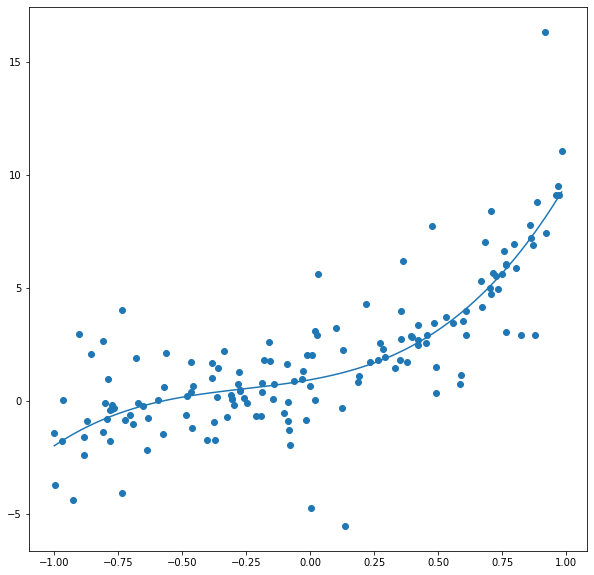

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

In [ ]:
model.visualize(x, y, True)

## Solve and Visualize for 4th Order (1.5 mark)

In [ ]:
order = 4
model = Regression(order)
x = np.array(data_O4['x'])
y = np.array(data_O4['y'])
x_four = np.power(x,4)
x_cube = np.power(x,3)
x_square = np.power(x,2)
#printing the coefficents that give the best least square error
x_func = np.stack((x_four, x_cube, x_square, x, np.ones((len(x)), dtype = int)), axis = 1)
model.solve(x_func,y,order)

array([[4.78812539],
       [3.20754131],
       [2.92028799],
       [2.17607008],
       [0.80139845]])

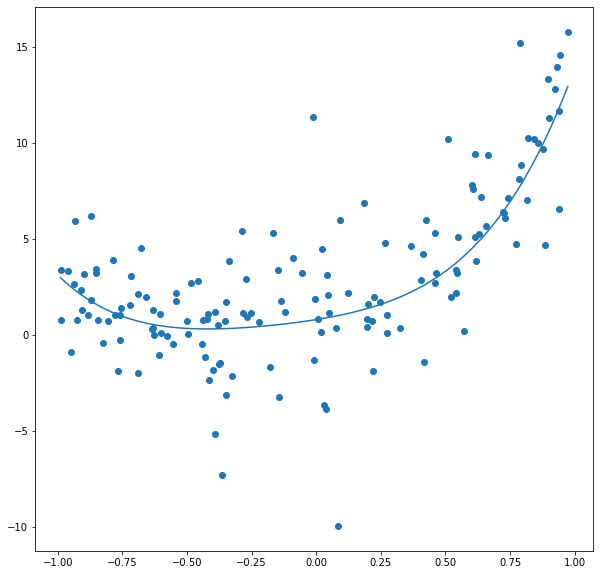

In [ ]:
plot_4 = model.visualize(x, y, True)